# Car Price Prediction (Based on the Ads on "Divar.ir")
In this project, we want to estimate the price of a given car based on its advertisement on "Divar.ir" (an Iranian website similar to "eBay"). For this purpose, it is necessary to first load the training and test data in the notebook and then clean it. For this, we need to know what characteristics our data has. So, with the help of Pandas library methods, we can see the first 5 rows of data.

In [ ]:
from __future__ import unicode_literals
!pip install https://github.com/sobhe/hazm/archive/master.zip --upgrade
from hazm import *
import pandas as pd
!pip install arabic-reshaper
!pip install python-bidi
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer, TfidfTransformer)
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/vehicles.csv')
initial_shape = data.shape
data.head()

,brand,category,created_at,description,image_count,mileage,price,title,year
0,NaN,heavy,Tuesday 07PM,سریال 43j$NUMبدون شکستگی سه حلقه لاستیک نو یک ...,4,NaN,-1,لودر کاتر پیلار 950,NaN
1,سایر,light,Wednesday 04AM,دوگانه ال پی جی بیمه با تخفیف دارد \nتودوزی نو...,3,180000.0,-1,پاترول شش سیلندر چهار درب,1366
2,پژو ۴۰۵::Peugeot 405,light,Wednesday 11AM,پژو 2000فنی تازه تعمیر بدنه بدون خطو خش تخیف ب...,0,290000.0,8500000,پژو مدل 81 مشکی,1381
3,نیسان::Nissan,light,Wednesday 01PM,سلام.\nماشین کاملا سالم همه چی فابریک متور زد ...,3,175000.0,19500000,پاترول 2در,1372
4,سمند::Samand,light,Thursday 07AM,سمند ال ایکس بدون رنگ تمامی سرویس ها انجام شده...,4,80000.0,23900000,سمند دوگانه کارخانه,1391


It can be seen that the data has 9 attribute columns. First, rows with undefined values are deleted. In this case, it is necessary to clear the "category" attribute column as well. Because the only value left for it will be "light". So it does not give us information. Also, we combine the description and title attribute columns, which are both text, to make them easier to clean up. We also delete the cars in "others" brand because their brand does not give us much information about them and any car can be included in this brand. Of course, if the number of data of this brand was more than the available number (about 7000), we should have considered another way to deal with them.<br>
To solve the problem of prices equal to -1, you can also put the average price of their brand instead of -1. It can be seen that if the "others" brand was not removed, we could not find a good substitute for the price equal to -1 in this segment. Finally, we can see that we have removed about 19,000 rows of data and reduced the number of feature columns to 7.

<u>Question: What did you do to solve the problem of missing values?</u><br>
As mentioned, nothing special can be done to solve this problem regarding "non-numerical" values. Therefore, we deleted the lines related to them. But for the price column, we replaced the missing values with the average price of their brand. The good thing about the second method is that we kept about 14,000 rows of data, and the bad thing is that we made this replacement without paying attention to the change of the "correlation" value of the price column with other columns. As a result, the price column's "correlation" value with other columns remained unchanged while we weighted about 10% of its data.

In [ ]:
data = data.dropna()
data = data.drop(data[data.year == '<1366'].index)
data['description'] = data['description'] + ' ' + data['title'] # combining 'description' with 'title' to drop 'title'
data = data.drop(['category', 'title'], axis=1) # the only available value for 'category' is 'light', 'created_at' doesn't affect on 'price'
data = data.drop(data[data.brand == 'سایر'].index)
################################################
xdata = data.drop(data[data.price == -1].index)
prices = dict()
for brand in data.brand.unique():
  prices[brand] = xdata.loc[xdata['brand'] == brand, 'price'].mean()
  print(f"<{brand}> : <{prices[brand]}>")
new_price = data.apply(lambda row: prices[row['brand']] if row['price'] == -1 else row['price'], axis=1)
data['price'] = new_price
################################################
present_shape = data.shape
print(f"\ninitial shape: {initial_shape}\npresent shape: {present_shape}\nno. of removed rows: {initial_shape[0] - present_shape[0]}")

<پژو ۴۰۵::Peugeot 405> : <17078086.536604512>
<نیسان::Nissan> : <28867015.966508918>
<سمند::Samand> : <19781183.448345713>
<ام‌وی‌ام::MVM> : <26805176.570895523>
<پراید صندوق‌دار::Pride> : <11430477.579598146>
<پراید هاچ‌بک::Pride> : <14005098.526666667>
<پژو پارس::Peugeot Pars> : <27564933.871460855>
<پژو ۲۰۶‍::Peugeot 206> : <21569490.64375572>
<پیکان::Peykan> : <6393577.957075963>
<وانت> : <11705117.470142977>
<پژو روآ / آر‌دی::RD/ROA> : <8134847.5631768955>
<پژو ۲۰۶‍ صندوق‌دار::Peugeot 206> : <27587205.731512606>
<تیبا::Tiba> : <20663826.806737587>
<زانتیا::Citroen Xantia> : <32182545.51966292>
<کیا::Kia> : <74298781.58608058>
<رنو::Renault> : <39323573.85799404>
<رانا::Runna> : <26681418.011257034>
<دوو::Daewoo> : <10993836.347197106>
<هیوندای (غیره)::Hyundai> : <102579782.99080348>
<تندر ۹۰::Tondar 90> : <30698278.450934578>
<تویوتا::Toyota> : <114282873.6375839>
<لیفان::Lifan> : <37903195.6097973>
<بنز::Mercedes-Benz> : <130263549.02678572>
<هیوندای سوناتا::Hyundai Sonata> : <96

In this section, we have to clear the description feature column that has Farsi and English words and numbers, remove punctuation marks and common words. Note that the stemming method is not used in this section because it reduces the accuracy. Also, we remove stop words with the help of "Hazm" library.

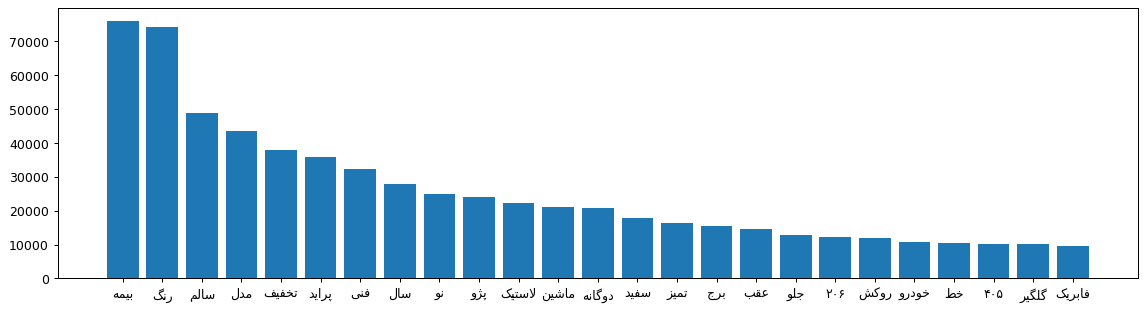

In [ ]:
normalizer = Normalizer()
punctuations = '''!()-[]{};:'"\,٬٫،<>./?@#$%٪^&*×ـ+=_~.؟؛«»|‌…'''
stops = set(stopwords_list())
common_words = ['تماس', 'شرط', 'فروش', 'سلام', 'واقعی', 'قیمت', 'دیوار', 'انجام', 'لطفا', 'تشکر', 'فروشی', 'راننده', 'NUM', 'باسلام', 'بشرط', 'بگیرید', 'باتشکر', 'مشتری', 'بگیرد',
                'بگیره', 'ممنون', 'سایت', 'دیگه', 'خرید', 'میام', 'پیامک', 'حرفهای'] # most nonsense words among 300 most common words
all_words = dict()
def normalize(description):
  my_str = normalizer.normalize(description)
  no_punct = ""
  for char in my_str:
    if char not in punctuations:
      no_punct = no_punct + char
  words = [word for word in word_tokenize(no_punct) if (word not in stops) and (word not in common_words) and (len(word) > 1)]
  for word in words:
    if word not in all_words.keys():
      all_words[word] = 1
    else:
      all_words[word] += 1
  return ' '.join(map(str, words))
new_description = data.apply(lambda row: normalize(row['description']), axis=1)
data['description'] = new_description
def _(text):
  return get_display(
      arabic_reshaper.reshape(u'%s' % str(text))
  )
sorted_words = dict(sorted(all_words.items(), key=lambda item: item[1], reverse=True))
words = list(sorted_words.keys())[0:25]
counts = list(sorted_words.values())[0:25]
fig = plt.figure(figsize=(12,3), dpi=90)
ax = fig.add_axes([0,0,1,1])
ax.bar(list(map(lambda x:_(x), words)), counts)
plt.show()

In the chart above, you can see what the 25 most common words were among the words in the description column, and as you can see, the most used words included 'insurance', 'color', 'technically sound', 'model', and 'discount'. Now, using the mentioned methods, we turn these keywords into features so that they can be used in learning models. Tables 1 and 2 show the effect of the number of words and the method used for the n-gram interval 1 to 2 and the linear regression model and decision tree. It should be noted that the lower the 'repetition frequency' parameter is in these two methods, the more the number of words used in learning increases. <br>
<table>
  <tr>
    <th></th>
    <th>Linear Regression</th>
    <th>Decision Tree</th>
  </tr>
  <tr>
    <td>693 words (min_df=500)</td>
    <td>12,176,862</td>
    <td>11,068,106</td>
  </tr>
  <tr>
    <td>190 words (min_df=2000)</td>
    <td>12,718,127</td>
    <td>11,462,169</td>
  </tr>
  <tr>
    <td>36 words (min_df=7500)</td>
    <td>13,130,367</td>
    <td>11,696,265</td>
  </tr>
  <tr>
    <td>24 words (min_df=10000)</td>
    <td>13,134,532</td>
    <td>11,400,497</td>
  </tr>
  <tr>
    <td>16 words (min_df=15000)</td>
    <td>13,162,480</td>
    <td>11,578,665</td>
  </tr>
</table>
<center>Table 1. RMSE of each model using TF-IDF method</center>

<table>
  <tr>
    <th></th>
    <th>Linear Regression</th>
    <th>Decision Tree</th>
  </tr>
  <tr>
    <td>693 words (min_df=500)</td>
    <td>12,402,463</td>
    <td>10,996,134</td>
  </tr>
  <tr>
    <td>190 words (min_df=2000)</td>
    <td>12,909,618</td>
    <td>11,238,776</td>
  </tr>
  <tr>
    <td>36 words (min_df=7500)</td>
    <td>13,173,764</td>
    <td>11,294,694</td>
  </tr>
  <tr>
    <td>24 words (min_df=10000)</td>
    <td>13,177,955</td>
    <td>11,286,835</td>
  </tr>
  <tr>
    <td>16 words (min_df=15000)</td>
    <td>13,195,561</td>
    <td>11,587,433</td>
  </tr>
</table>
<center>Table 2. RMSE of each model using CountVectorizer method</center>

<u>Question: Analyze the results of using different text processing criteria and different word counts.</u><br>
As can be seen in Tables 1 and 2, the accuracy of the output improves by increasing the number of words (or decreasing the minimum frequency). Of course, if we include too many words in learning, the "overfit" phenomenon occurs. However, this cannot be easily demonstrated because the RAM overflow problem is observed earlier. On the other hand, reducing word count does not necessarily mean reducing accuracy. Rather, it can be seen that an acceptable accuracy can be achieved with about 24 words, while with 36 words, the accuracy will be less. Therefore, it can be assumed that as the number of words decreases, the bias generally increases and we go towards "underfit".<br>
Regarding text processing criteria, it can be said that the criteria in Table 1 performed better for linear regression, while the criteria in Table 2 performed better for decision trees. In relation to the random forest, it was also observed that the performance of the criterion in Table 2 is optimal.<br>
The best result obtained in this project is by using the method of table 2 and the random forest model, which takes a long time to train on 693 words, so we settled for 24 words and the information given from here on is related to the same number.

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), min_df=10000)
# count_vectorized = vectorizer.fit_transform(data['description'])
# tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
# vectorized = tfidf_transformer.fit_transform(count_vectorized)
vectorized = vectorizer.fit_transform(data['description'])
description = pd.DataFrame(vectorized.toarray(), index=list(data.index), columns=vectorizer.get_feature_names())
description

,برج,بیمه,بیمه برج,تخفیف,تخفیف بیمه,تمیز,جلو,خط,دوگانه,رنگ,روکش,سال,سالم,سفید,عقب,فنی,فنی سالم,لاستیک,ماشین,مدل,نو,پراید,پژو,۲۰۶
2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,2,0
3,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0
6,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130436,1,1,1,0,0,1,0,0,0,2,0,1,0,0,0,0,0,1,0,2,0,1,0,0
130437,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
130440,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
130441,0,2,0,0,0,0,0,0,0,1,0,2,3,0,0,2,1,0,1,0,0,1,0,0


<u>Question: What method have you used to convert batch data into usable information for models and why?</u><br>
We know that batch data can be converted into usable information for machine learning models by two common methods "labeling" and "one-hot encoding". In this project, we had to use the "labeling" method to work with the brand attribute column to draw the "Mutual Information Gain" diagram. Because the computing power required in case of using the second method was very high. However, after getting the required output, we proceeded to "one-hot encoding" this column, and the reason for this is that different car brands cannot be rated in general; for example, a car with brand X is not necessarily more expensive than a car with brand Y, if X > Y. So, it has nothing to do with the brand. Therefore, it is better to consider each brand as a feature and attribute its presence or absence to each row. Experiments have shown that using the "labeling" method in this project can weaken the result by 11%.

In [ ]:
rated_dummies = pd.get_dummies(data.brand)
# label encoding is temporal due to insufficient RAM while running the next part
le = LabelEncoder()
data['brand'] = le.fit_transform(data['brand'])
data['created_at'] = le.fit_transform(data['created_at'])
data = data.drop(['description'], axis=1)
data.head()

,brand,created_at,image_count,mileage,price,year
2,22,164,0,290000.0,8500000.0,1381
3,12,145,3,175000.0,19500000.0,1372
4,10,108,4,80000.0,23900000.0,1391
5,22,110,3,125000.0,8500000.0,1384
6,0,110,2,11000.0,18500000.0,1393


#Mutual Information Gain in Regression

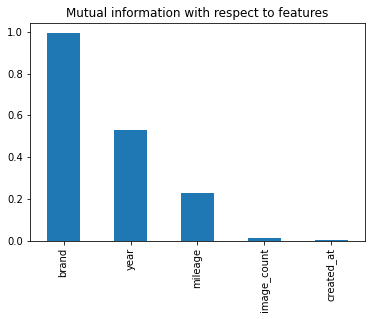

In [ ]:
y = data.loc[:, data.columns == 'price']
x = data.loc[:, data.columns != 'price']
mi = mutual_info_regression(x, y.to_numpy().reshape(y.shape[0],))
mi = pd.Series(mi)
mi.index = data.loc[:, data.columns != 'price'].columns
mi.sort_values(ascending=False, inplace = True)
plt.title('Mutual information with respect to features')
mi.plot.bar()
plt.show()

<u>Question: What information does the output diagram of the previous cell give us?</u><br>
It can be seen that the car brand has the most impact on the price, and after that, the year of manufacture and the distance traveled (mileage) are the most important features of each car to determine its price. Since the number of images and the day of creating the ad have the least impact on the price, we will remove these feature columns.


In [ ]:
data = pd.concat([data, rated_dummies], axis=1) # don't run this line more than once
data = data.drop(['brand', 'image_count', 'created_at'], axis=1)
data.head()

,mileage,price,year,ام‌وی‌ام::MVM,بنز::Mercedes-Benz,بی‌ام‌و::BMW,تندر ۹۰::Tondar 90,تویوتا::Toyota,تیبا::Tiba,دوو::Daewoo,رانا::Runna,رنو::Renault,زانتیا::Citroen Xantia,سمند::Samand,لیفان::Lifan,نیسان::Nissan,هیوندای (غیره)::Hyundai,هیوندای سوناتا::Hyundai Sonata,وانت,پراید صندوق‌دار::Pride,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia
2,290000.0,8500000.0,1381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,175000.0,19500000.0,1372,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,80000.0,23900000.0,1391,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,125000.0,8500000.0,1384,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,11000.0,18500000.0,1393,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


So far, we have removed some of the less important feature columns and replaced the brand column with feature columns from different brands. Now, we divide the obtained data into two parts, training and testing, and consider 10% of the data for testing our models. It can be seen that the number of attribute columns has reached 51. We will see that by increasing the number of words (or decreasing the minimum frequency) the output of some models can be improved, while increasing it too much can lead to "overfit" and reduce accuracy. Of course, it should be noted that for some models (for example, the decision tree), if the number of words (or feature columns) exceeds a limit, we will also face the problem of lack of sufficient RAM.

In [ ]:
data = pd.concat([data, description], axis=1) # don't run this line more than once
y = data.loc[:, data.columns == 'price']
x = data.loc[:, data.columns != 'price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)
print(f"x_train.shape = {x_train.shape}\nx_test.shape = {x_test.shape}")

x_train.shape = (99746, 51)
x_test.shape = (11083, 51)


At this stage, the initial data cleaning work is finished and it can be seen that the final data has 99,746 rows for training and 11,083 rows for testing. Also, the number of feature columns of the final data is 51.<br>
<u>Question: Analyze the different modes of dividing data into testing and training.</u><br>
<table>
  <tr>
    <th></th>
    <th>Linear Regression</th>
    <th>Decision Tree</th>
  </tr>
  <tr>
    <td>60%</td>
    <td>13,544,955</td>
    <td>11,635,248</td>
  </tr>
  <tr>
    <td>10%</td>
    <td>13,177,955</td>
    <td>11,286,835</td>
  </tr>
  <tr>
    <td>2%</td>
    <td>13,182,999</td>
    <td>11,555,704</td>
  </tr>
</table>
<center>Table 3. RMSE of each model using different amounts of data as test data</center>

It is clear that considering 2% of the data for testing causes "overfit" to occur due to the increase in variance, and considering 60% of them causes "underfit" to occur due to the increase in bias. Usually, in machine learning models, the focus is on increasing the variance, and as a result, measures should be taken to reduce the bias, including collecting more data (or assigning a higher percentage to training) and reducing the feature space.

#Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
print(f"mse: {mse}\nrmse: {rmse}")

mse: 173658521975220.0
rmse: 13177955.910353472


# KNN

Choosing low values for K can cause "overfit" and choosing high values can increase the bias and cause "underfit". As a result, a suitable value for K should be found. This value will be equal to 6. As you know, K determines the number of nearest neighbors in the feature space for each record. It can be seen that this method is not suitable for this problem. The reason for this is that this method is usually used for classification and is not suitable for regression. It should be noted that this model performs better than linear regression when the SNR is high, that is, when the noise power is lower than the signal power. We know that in this problem, we have a lot of noisy features that weaken the performance of this model.

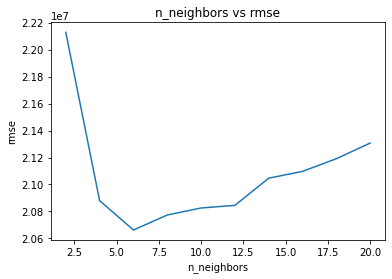

In [ ]:
x = []
for i in range(2, 22, 2):
  model = KNeighborsRegressor(n_neighbors=i)
  model.fit(x_train, y_train.to_numpy().ravel())
  y_predict = model.predict(x_test)
  mse = mean_squared_error(y_test, y_predict)
  rmse = np.sqrt(mse)
  x.append(rmse)
plt.title('n_neighbors vs rmse')
plt.plot(np.arange(2, 22, 2), x)
plt.xlabel('n_neighbors')
plt.ylabel('rmse')
plt.show()

In [ ]:
model = KNeighborsRegressor(n_neighbors=6)
model.fit(x_train, y_train.to_numpy().ravel())
y_predict = model.predict(x_test)
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
print(f"mse: {mse}\nrmse: {rmse}")

mse: 426941728928282.8
rmse: 20662568.304261763


# Decision Tree

<u>Question: What effect does the change of the "max_depth" parameter have on the output of this model?</u><br>
As you can see in the output graphs of the next cell, increasing this parameter can cause more information to be extracted and checked, and as a result, the accuracy of the output will improve. However, increasing it too much can cause "overfit" and reduce the accuracy of the test. This type of learning increases the variance and is not general. That is, it only knows how to estimate the data it has seen. On the other hand, too little of max_depth can make a very simple model and take the power of estimation from it. This type of model has a lot of bias and is "underfit".

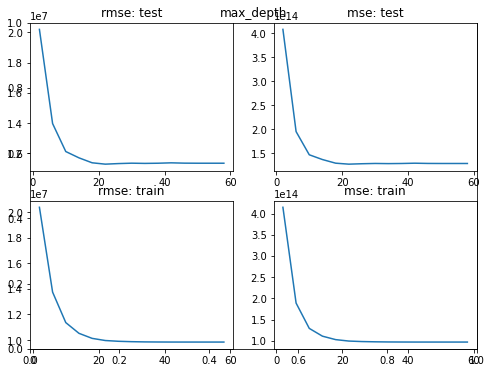

In [ ]:
x = []
y = []
x_true = []
y_true = []
for i in range(2, 62, 4):
  regressor = DecisionTreeRegressor(max_depth=i, min_samples_split=70, random_state=42)
  regressor.fit(x_train, y_train)
  y_predict = regressor.predict(x_test)
  y_true_predict = regressor.predict(x_train)
  mse = mean_squared_error(y_test, y_predict)
  mse_true = mean_squared_error(y_train, y_true_predict)
  rmse = np.sqrt(mse)
  rmse_true = np.sqrt(mse_true)
  y.append(mse)
  y_true.append(mse_true)
  x.append(rmse)
  x_true.append(rmse_true)
fig = plt.figure(figsize=(8,6))
plt.title('max_depth')
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.title.set_text('rmse: test')
ax2.title.set_text('mse: test')
ax3.title.set_text('rmse: train')
ax4.title.set_text('mse: train')
ax1.plot(np.arange(2, 62, 4), x)
ax2.plot(np.arange(2, 62, 4), y)
ax3.plot(np.arange(2, 62, 4), x_true)
ax4.plot(np.arange(2, 62, 4), y_true)
plt.show()

The "min_samples_split" parameter is very effective on the output of this model. Because it determines the minimum number of instances on each node for that node to split. Therefore, it can be used to increase the generation of nodes that are more likely to occur. As a result, it got a better result in less time. According to the cell output diagram below, the best value for this parameter is 70. Too much of this parameter can result in "overfit" phenomenon, as well as being too low also causes "underfit".

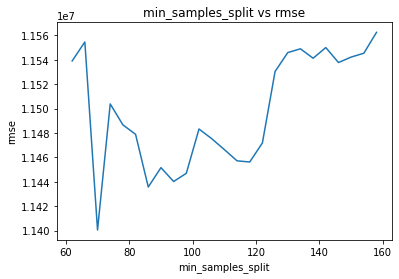

In [ ]:
x = []
for i in range(62, 162, 4):
  regressor = DecisionTreeRegressor(max_depth=22, min_samples_split=i, random_state=42)
  regressor.fit(x_train, y_train)
  y_predict = regressor.predict(x_test)
  mse = mean_squared_error(y_test, y_predict)
  rmse = np.sqrt(mse)
  x.append(rmse)
plt.title('min_samples_split vs rmse')
plt.plot(np.arange(62, 162, 4), x)
plt.xlabel('min_samples_split')
plt.ylabel('rmse')
plt.show()

In [ ]:
regressor = DecisionTreeRegressor(max_depth=22, min_samples_split=70, random_state=42)
regressor.fit(x_train, y_train)
y_predict = regressor.predict(x_test)
y_true_predict = regressor.predict(x_train)
mse = mean_squared_error(y_test, y_predict)
mse_true = mean_squared_error(y_train, y_true_predict)
rmse_true = np.sqrt(mse_true)
rmse = np.sqrt(mse)
print(f"mse: {mse}\nrmse: {rmse}\nrmse on training set: {rmse_true}")

mse: 127392656823456.95
rmse: 11286835.554018538
rmse on training set: 9958954.428568052


# Random Forest

In this section, we will examine the features of the random forest and see which features have a greater impact on the final result. To begin with, we consider the number of decision trees in the forest. The higher this number is, the more robust the model will be and its variance will decrease. As a result, the probability of "overfitting" the model is reduced. Usually, this parameter is determined after setting other parameters, whose increase will increase the training time.<br>
According to the output diagram of the cell below, it can be said that 58 trees will be enough in this forest. Because its higher number does not change much in the accuracy of the output.

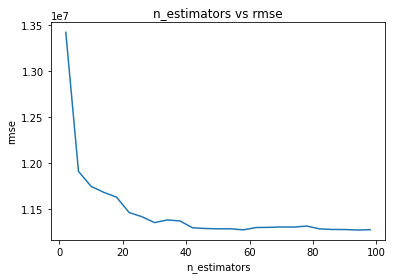

In [ ]:
x = []
for i in range(2, 102, 4):
  regressor = RandomForestRegressor(n_estimators=i, criterion='mse', random_state=42)
  regressor.fit(x_train, y_train.to_numpy().ravel())
  y_predict = regressor.predict(x_test)
  mse = mean_squared_error(y_test, y_predict)
  rmse = np.sqrt(mse)
  x.append(rmse)
plt.title('n_estimators vs rmse')
plt.plot(np.arange(2, 102, 4), x)
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.show()

The depth parameter of each tree is very decisive for a single decision tree. Because it can produce or lose various combinations of decisions. However, in random forest, this parameter will not have much effect, and its excessive amount may cause "overfit". Anyhow, according to the output diagram of the cell below, we choose the number 18 for this parameter.

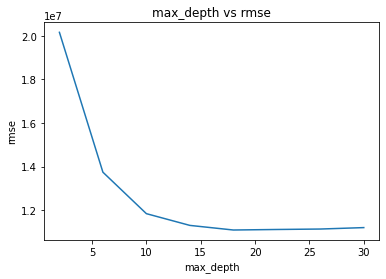

In [ ]:
x = []
for i in range(2, 34, 4):
  regressor = RandomForestRegressor(n_estimators=58, max_depth=i, criterion='mse', random_state=42)
  regressor.fit(x_train, y_train.to_numpy().ravel())
  y_predict = regressor.predict(x_test)
  mse = mean_squared_error(y_test, y_predict)
  rmse = np.sqrt(mse)
  x.append(rmse)
plt.title('max_depth vs rmse')
plt.plot(np.arange(2, 34, 4), x)
plt.xlabel('max_depth')
plt.ylabel('rmse')
plt.show()

The next parameter is the "min_samples_split". As mentioned, this parameter is effective on the decision tree, while it does not have much effect on the random forest. According to the cell output diagram below, the best value for this parameter is 30.

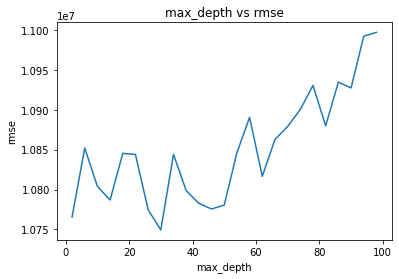

In [ ]:
x = []
for i in range(2, 102, 4):
  regressor = RandomForestRegressor(n_estimators=58, max_features=0.3, max_depth=18, min_samples_split=i, criterion='mse', random_state=42)
  regressor.fit(x_train, y_train.to_numpy().ravel())
  y_predict = regressor.predict(x_test)
  mse = mean_squared_error(y_test, y_predict)
  rmse = np.sqrt(mse)
  x.append(rmse)
plt.title('max_depth vs rmse')
plt.plot(np.arange(2, 102, 4), x)
plt.xlabel('max_depth')
plt.ylabel('rmse')
plt.show()

The next parameter is very important. This parameter is "max_features". The best value for it is obtained by trial and error. We will see that small values for this parameter, that is, considering a small number of features when dividing the node, will reduce the variance and, as a result, reduce the probability of "overfit". However, it increases the height of the forest trees. Therefore, we should also consider the "max_depth" so that it does not hinder learning. It should be noted that despite the noise characteristics in the present dataset, we have to use higher values of this parameter. Because we need to increase the probability of each feature participating in the competition for node division. Otherwise, few features can perform node splitting at a time.<br>
Increasing the value of this parameter reduces the bias and thus reduces the probability of "underfit" and at the same time, it may lead to an increase in variance and the occurrence of "overfit". Finally, with the help of the grid search method, the value of 0.3 was chosen for this parameter.

In [ ]:
gsc = GridSearchCV(
        estimator=regressor,
        param_grid=
        {'max_features': [0.2, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7]},
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(x_train, y_train.to_numpy().ravel())
best_params = grid_result.best_params_
best_params

{'max_features': 0.3}

In [ ]:
regressor = RandomForestRegressor(n_estimators=58, max_features=0.3, criterion='mse', max_depth=18, min_samples_split=30, random_state=42)
regressor.fit(x_train, y_train.to_numpy().ravel())
y_predict = regressor.predict(x_test)
y_true_predict = regressor.predict(x_train)
mse = mean_squared_error(y_test, y_predict)
mse_true = mean_squared_error(y_train, y_true_predict)
rmse = np.sqrt(mse)
rmse_true = np.sqrt(mse_true)
print(f"mse: {mse}\nrmse: {rmse}\nrmse on training set: {rmse_true}")

mse: 117368438704471.28
rmse: 10833671.524671186
rmse on training set: 9744239.48828721


The best result was obtained on the random forest model with the "TF-IDF" method and the number of 720 features. The value of "rmse" in this case was equal to 10 million and 242 thousand. The training of this model took about 2 minutes.

<u>Question: Compare random forest and decision tree models in terms of bias and variance.</u><br>
Bias is the difference between the average estimate of the model and the actual value. The model with high bias pays little attention to the training data and is oversimplified and produces high error. On the other hand, the model with high variance pays too much attention to the training data and does not generalize. As a result, it works well on the training data and not on the test data. In other words, it suffers "overfit". Therefore, the goal is always to establish a compromise between these two values. It means that the model should be simple and have a high compatibility with the data that has not been seen in advance. You can see the diagram of these two criteria in the figure below.<br>
As seen, the "rmse" criterion for testing and training data is closer to each other in the random forest model. Therefore, the performance of this model on bias and variance has been more appropriate. Of course, we know that in general, the random forest model focuses more on preventing the increase of bias and the occurrence of "overfit".

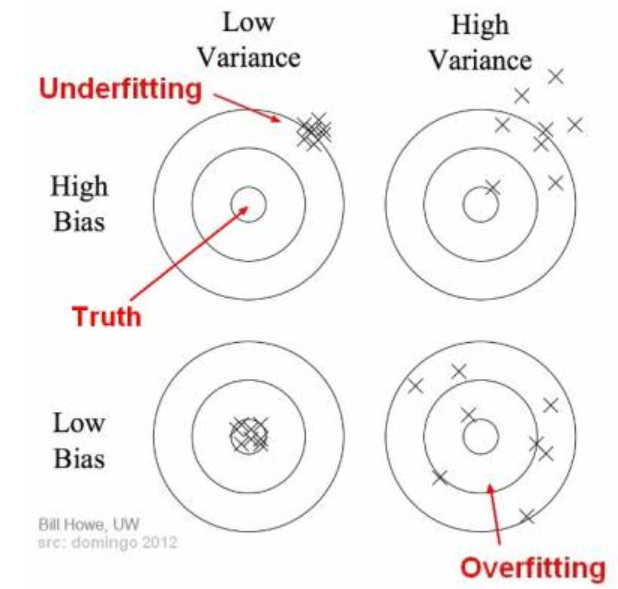